In [ ]:
!pip install rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import ee
import geemap
import json
import datetime
from ipyleaflet import GeoJSON
import rasterio
from google.colab import files


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 35.3 MB/s eta 0:00:00


In [ ]:
# Authenticate Earth Engine
from google.colab import userdata
userdata.get('EE_PROJECT_ID')
ee.Authenticate()

In [ ]:
ee.Initialize(project = 'ee-praca-ks')

## Chapter 1 - Preprocessing

In [ ]:
Map = geemap.Map()

In [ ]:
POINT_STATION_DATA = r"Zestaw-stacji-WGS84.json"
RESEARCH_AREA = r"obszar_badan.geojson"
SELECTED_AREAS = r"wybrane_obszary_stacje.geojson"
METEO_DATA = r"DaneMeteo.xlsx"
DATA_FILE = r'C:\Users\Kacper.Sobczyk\Desktop\mgr\Dane_ML.csv'

In [ ]:
with open(POINT_STATION_DATA) as file:
    json_data = json.load(file)
meteo_stations = GeoJSON(
    data = json_data,
    point_style = {'color': "red",
                   'radius': 3,
                   'weight': 1}
)
Map = geemap.Map(center=(50.25,20),zoom=9)
Map.add_layer(meteo_stations)
research_area = geemap.geojson_to_ee(RESEARCH_AREA)
Map.add_layer(research_area)

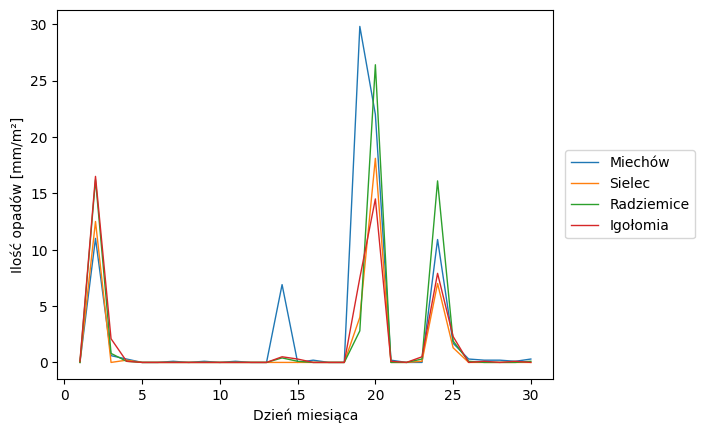

In [ ]:
stacje_id = {250200210: 'Miechów',
             250200220: 'Sielec',
             250200250: 'Radziemice',
             250200280: 'Igołomia'}
colnames = ["ID", "File code", "Date", "Value [mm/m2]"]
dane_atm= pd.read_csv('B00604S_2023_09.csv',delimiter=';',names=colnames, usecols=range(4),decimal=',')
dane_atm['Date'] = pd.to_datetime(dane_atm['Date'])
filter = dane_atm["ID"].isin(stacje_id.keys())
data_filtered = dane_atm[filter].groupby('ID')
for group, grouped_data in data_filtered:
    plt.plot(grouped_data['Date'].dt.day, grouped_data['Value [mm/m2]'], label=stacje_id[group], linewidth=1)
plt.xlabel('Dzień miesiąca')
plt.ylabel('Ilość opadów [mm/m²]')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))

In [ ]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
filtered = S2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
  .filterDate('2023-09-20','2023-09-26') \
  .filter(ee.Filter.bounds(research_area))

image = filtered.median()
landcov = ee.ImageCollection("ESA/WorldCover/v100").first()
land_cover = landcov.select('Map');
visualization = {
  'bands': ['Map']
}

Map.addLayer(image.clip(research_area), {'min': 0.0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}, 'World Imagery')

#Maska z łąkami i polami
condition1 = landcov.eq(30)
condition2 = landcov.eq(40)
landcov_mask = condition1.Or(condition2).clip(research_area)

Map.addLayer(landcov_mask, {}, 'Map coverage - polygon')

mndwi = image.normalizedDifference(['B3', 'B11']).rename(['mndwi'])
mndwi = mndwi.updateMask(mndwi.gt(-0.3))

Map.addLayer(mndwi.clip(research_area), {'palette': ['white', 'blue']}, 'MNDWI')
awei = image.expression(
    '4*(GREEN - SWIR1) - (0.25*NIR + 2.75*SWIR2)', {
      'GREEN': image.select('B3').multiply(0.0001),
      'NIR': image.select('B8').multiply(0.0001),
      'SWIR1': image.select('B11').multiply(0.0001),
      'SWIR2': image.select('B12').multiply(0.0001),

}).rename('awei');
awei = awei.updateMask(awei.gt(-0.5))

Map.addLayer(awei.clip(research_area), {'palette': ['white', 'purple']}, 'AWEI')


In [ ]:
def maskS1clouds(image):
    vv = image.select('VV')
    vh = image.select('VH')
    return image.addBands(vv.rename('VV')).addBands(vh.rename('VH'))

def detectWater(image):
    moisture_index = image.select('VV').add(image.select('VH')).divide(2)
    water = moisture_index.lt(-18)  # Próg dla detekcji wody
    return image.updateMask(water)

S1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
  .filterBounds(research_area) \
  .filterDate('2023-09-20','2023-09-26') \
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
  .filter(ee.Filter.eq('instrumentMode', 'IW')) \
  .map(maskS1clouds) \
  .mosaic()

# Zastosowanie funkcji do danych Sentinel-1
moisture_index = S1.select('VV').add(S1.select('VH')).divide(2)
water_mask = moisture_index.lt(-18)

test_index = S1.select('VH').multiply(4).divide(S1.select('VV').add(S1.select('VH')))
Map.addLayer(S1.clip(research_area), {}, 'S1')

In [ ]:
# maska binarna
bin_mndwi = mndwi.unmask(0).gt(0)
bin_awei = awei.unmask(0).gt(0)
bin_sar = water_mask.unmask(0).gt(0)
combined_binary_layer = bin_mndwi.And(bin_awei).And(bin_sar).And(landcov_mask)

binary_0 = combined_binary_layer.updateMask(combined_binary_layer.eq(0)).visualize(**{
    'min': 0,
    'max': 0,
    'palette': ['black'],
    'opacity': 0.00001
})
binary_1 = combined_binary_layer.updateMask(combined_binary_layer.eq(1)).visualize(**{
    'min': 1,
    'max': 1,
    'palette': ['blue'],
    'opacity': 0.6
})

Map.addLayer(ee.ImageCollection([binary_0, binary_1]),{}, 'Combined Binary Layer')
Map

Map(center=[50.25, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

## Chapter 2 - Standing Water Area

In [ ]:
S1_dates_dict = {
    'start_date': ['2021-06-25', '2021-07-18', '2021-07-26', '2021-08-06', '2021-08-25', '2021-09-02', '2022-07-10', '2022-07-30', '2023-05-19', '2023-06-15', '2023-07-26', '2023-08-10', '2023-08-29', '2023-09-21'],
    'end_date': ['2021-06-30', '2021-07-20', '2021-07-29', '2021-08-09', '2021-08-28', '2021-09-03', '2022-07-12', '2022-08-01', '2023-05-22', '2023-06-18', '2023-07-31', '2023-08-12', '2023-09-01', '2023-09-27']
}
S1_dates_dry_dict = {
    'start_date': ['2021-06-19', '2022-05-20', '2022-06-25', '2023-05-30', '2023-06-03', '2023-08-18'],
    'end_date': ['2021-06-22', '2022-05-21', '2022-06-28', '2023-06-01', '2023-06-05', '2023-08-20']
}


In [ ]:
# Create binary SAR images
SAR_images_list = []
new_SAR_images_list = []
for i in range(len(S1_dates_dict['start_date'])):
  S1_new = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(research_area) \
    .filterDate(S1_dates_dict['start_date'][i],S1_dates_dict['end_date'][i]) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .map(maskS1clouds) \
    .mosaic()
  moisture_index = (S1_new.select('VV').add(S1_new.select('VH'))).divide(2)
  # RVI_1 = S1_new.select('VH').multiply(4).divide(S1_new.select('VV').add(S1_new.select('VH')))
  water_mask = S1_new.select('VV').lt(-16).And(S1_new.select('VH').lt(-19)).clip(research_area)
  SAR_images_list.append(water_mask.And(landcov_mask))

SAR_data = ee.ImageCollection(SAR_images_list)
summary_data = SAR_data.sum()


# Maski
range1 = summary_data.eq(0)
range2 = summary_data.gte(1).And(summary_data.lte(3))
range3 = summary_data.gte(4).And(summary_data.lte(5))
range4 = summary_data.gte(6).And(summary_data.lte(7))
range5 = summary_data.gte(8).And(summary_data.lte(9))
range6 = summary_data.gte(10)

colored1 = summary_data.updateMask(range1).visualize(**{
    'min': 0,
    'max': 0,
    'palette': ['FFFFFF'],
    'opacity': 0.0001
})
colored2 = summary_data.updateMask(range2).visualize(**{
    'min': 1,
    'max': 3,
    'palette': ['#a1f0f7'],
    'opacity': 0.25
})
colored3 = summary_data.updateMask(range3).visualize(**{
    'min': 4,
    'max': 5,
    'palette': ['#4ea2f5'],
    'opacity': 0.5
})
colored4 = summary_data.updateMask(range4).visualize(**{
    'min': 6,
    'max': 7,
    'palette': ['#1e71f7'],
    'opacity': 0.8
})
colored5 = summary_data.updateMask(range5).visualize(**{
    'min': 8,
    'max': 9,
    'palette': ['#020fbf'],
    'opacity': 0.8
})
colored6 = summary_data.updateMask(range6).visualize(**{
    'min': 10,
    'max': 14,
    'palette': ['#001452'],
    'opacity': 0.8
})

summary_data = ee.ImageCollection([colored1, colored2, colored3, colored4, colored5, colored6])
Map.addLayer(summary_data, {}, 'Summed Image')

for i in range(len(S1_dates_dry_dict['start_date'])):
  S1_new = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(research_area) \
    .filterDate(S1_dates_dry_dict['start_date'][i],S1_dates_dry_dict['end_date'][i]) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .map(maskS1clouds) \
    .mosaic()
  moisture_index = (S1_new.select('VV').add(S1_new.select('VH'))).divide(2)
  water_mask = S1_new.select('VV').lt(-18).And(S1_new.select('VH').lt(-20)).clip(research_area)
  new_SAR_images_list.append(water_mask.And(landcov_mask))
dry_SAR_data = ee.ImageCollection(new_SAR_images_list)
summary_dry_data = dry_SAR_data.sum()


dry_range1 = summary_dry_data.eq(0)
dry_range2 = summary_dry_data.gte(1).And(summary_dry_data.lte(2))
dry_range3 = summary_dry_data.gte(3).And(summary_dry_data.lte(4))
dry_range4 = summary_dry_data.gte(5).And(summary_dry_data.lte(6))

new_colored1 = summary_dry_data.updateMask(dry_range1).visualize(**{
    'min': 0,
    'max': 0,
    'palette': ['FFFFFF'],
    'opacity': 0.0001
})
new_colored2 = summary_dry_data.updateMask(dry_range2).visualize(**{
    'min': 1,
    'max': 2,
    'palette': ['#f7c76d'],
    'opacity': 0.00001
})
new_colored3 = summary_dry_data.updateMask(dry_range3).visualize(**{
    'min': 3,
    'max': 4,
    'palette': ['#f5b745'],
    'opacity': 0.5
})
new_colored4 = summary_dry_data.updateMask(dry_range4).visualize(**{
    'min': 5,
    'max': 6,
    'palette': ['#ed9b05'],
    'opacity': 0.8
})
summary_dry_data = ee.ImageCollection([new_colored1, new_colored2, new_colored3, new_colored4])
Map.addLayer(summary_dry_data, {}, 'High polarisation on dry area')

In [ ]:
Map

Map(bottom=44610.0, center=[50.25, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

## Chapter 3 - Data preparing

In [ ]:
selected_areas = gpd.read_file(SELECTED_AREAS)
features = []
for _, row in selected_areas.iterrows():
    geometry = ee.Geometry(mapping(row['geometry']))
    feature = ee.Feature(geometry, {'OBJECTID': row['OBJECTID'],
                                    'Station_ID': row['Station_ID']})
    features.append(feature)

feature_collection = ee.FeatureCollection(features)
Map.addLayer(feature_collection, {}, 'Polygons')
Map

Map(bottom=177434.0, center=[50.297235294280476, 20.49362898755117], controls=(WidgetControl(options=['positio…

In [ ]:
# Funkcja do wyznaczania pory roku na podstawie daty
def set_season(image_date):
  if (image_date.month in [4, 5] or
      (image_date.month == 6 and image_date.day < 22) or
      (image_date.month == 3 and image_date.day >= 21)) :
    return 1
  elif (image_date.month in [7, 8] or
      (image_date.month == 9 and image_date.day < 23) or
      (image_date.month == 6 and image_date.day >= 22)) :
    return 2
  if (image_date.month in [10, 11] or
      (image_date.month == 12 and image_date.day < 22) or
      (image_date.month == 9 and image_date.day >= 23)) :
    return 3
  elif (image_date.month in [1, 2] or
      (image_date.month == 3 and image_date.day < 21) or
      (image_date.month == 12 and image_date.day >= 22)) :
    return 4

# Zainicjalizowanie okresu badań
start_time = datetime.date(2021, 1, 1)
end_time = datetime.date(2024, 6, 29)

# Wczytanie danych meteo z pliku csv
meteo_df = pd.read_excel(METEO_DATA)
meteo_df["Date"] = pd.to_datetime(meteo_df[['Year', 'Month', 'Day']])

# Zainicjalizowanie zmiennych:
# - datasets - lista do przechowywania uzupełnionych danych w formie słowników
# - dates_list - słownik do przechowywania listy dat, które już zostały użyte dla danego
#                obszaru stworzone po to, by obrazy się nie powtarzały
# - index - iterator
datasets = []
dates_list = {}
index=1

# Ustawienie słownika dates_list
for i in range(19):
  dates_list[f"Area {i+1}"] = []

# Główna pętla w której występuje 57 iteracji
for i in range(57):
  # Inicjalizacja słownika do przechowywania danych
  template_dict = {
      'area_id': (i % 19) + 1,
      'month': None,
      'season': None,
      'day_id': None,
      'temperature': None,
      'humidity': None,
      'rainfall': None,
      'image': None,
      'raster_name': None
  }
  # Wyciągnięcie granic obszaru z zestawu obszarów (FeatureCollection) oraz wyciągnięcie
  # identyfikatora stacji meteo znajdującej się najbliżej iterowanego obszaru.
  selected_polygon = feature_collection.filter(ee.Filter.eq('OBJECTID', template_dict["area_id"])).first()
  station = selected_polygon.get('Station_ID').getInfo()

  # Ustawienie okresu badań do losowania daty
  date_range = pd.date_range(start=start_time, end=end_time)

  # Inicjalizacja pętli, która wykonuje się do momentu, aż wszystkie warunki
  # zostaną spełnione
  while True:
    # Losowanie i przetworzenie daty do poprawnego typu
    random_date = np.random.choice(date_range)
    random_date = datetime.datetime.utcfromtimestamp(random_date.astype(int) * 1e-9).date()

    # Ekstrakcja pięciodniowego okresu do obliczenia danych meteo
    end_date = random_date + datetime.timedelta(days=1)
    pre_date = random_date - datetime.timedelta(days=4)
    filtered_df = meteo_df[(meteo_df['Station ID'] == station) &
                           (meteo_df['Date'] <= random_date.strftime('%Y-%m-%d')) &
                            (meteo_df['Date'] >= pre_date.strftime('%Y-%m-%d'))]
    filtered_df = filtered_df.sort_values('Date')

    # Warunek, który zapezpiecza przed wyjściem za okres badań
    if pre_date < start_time:
      continue

    # Nadanie wag, jeśli dane są niepełne, to pętla while się przerwie
    # i zacznie robić od nowa
    weights = [1, 2, 3, 4, 5]
    try:
      filtered_df["Weight"] = weights
    except ValueError:
      continue

    # Wczytanie obrazu radarowego z dnia wylosowanej daty
    Image = ee.ImageCollection('COPERNICUS/S1_GRD') \
      .filterBounds(selected_polygon.geometry()) \
      .filterDate(random_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')) \
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
      .filter(ee.Filter.eq('instrumentMode', 'IW')) \
      .map(maskS1clouds)

    # Sprawdzenie, czy dla podanej daty istnieje jakiś obraz radarowy oraz czy data
    # wystąpiła pierwszy raz - jeśli nie, to pętla while kontynuuje swoje
    # nieskończone działanie
    images_number = Image.size().getInfo()
    if (images_number > 0 and
        random_date not in dates_list[f"Area {template_dict['area_id']}"]):
      img = Image.mosaic()

      # Przypisanie wartości do słownika danych
      template_dict['image'] = img.select(['VV', 'VH']).clip(selected_polygon.geometry())
      template_dict['month'] = random_date.month
      template_dict['season'] = set_season(random_date)
      template_dict['day_id'] = (random_date - datetime.date(2021,1,1)).days + 1
      template_dict['temperature'] = round((filtered_df['Temperature'] *
                                            filtered_df['Weight']).sum() / filtered_df['Weight'].sum(),2)
      template_dict['humidity'] = round((filtered_df['Humidity'] *
                                         filtered_df['Weight']).sum() / filtered_df['Weight'].sum(),2)
      template_dict['rainfall'] = round((filtered_df['Rainfall'] *
                                         filtered_df['Weight']).sum() / filtered_df['Weight'].sum(),2)
      template_dict['raster_name'] = f"Raster_{index}.tif"

      # Wspomniany warunek, że dla pierwszych 19 iteracji dane będą pobrane
      # z okresów poopadowych
      if index <= 19:
        if template_dict['rainfall'] < 15:
          continue

      # Wstawienie słownika do listy z danymi
      datasets.append(template_dict)

      # Dopisanie daty wykonania obrazu do listy dat użytych
      dates_list[f"Area {template_dict['area_id']}"].append(random_date)
      print(template_dict)

      #Zwiększenie iteratora o 1 i przewanie pętli while
      index += 1
      break


{'area_id': 1, 'month': 8, 'season': 2, 'day_id': 236, 'temperature': 18.82, 'humidity': 75.13, 'rainfall': 19.1, 'image': <ee.image.Image object at 0x7f9fdee1ec50>, 'raster_name': 'Raster_1.tif'}
{'area_id': 2, 'month': 7, 'season': 2, 'day_id': 576, 'temperature': 24.91, 'humidity': 54.07, 'rainfall': 21.22, 'image': <ee.image.Image object at 0x7f9fdee1c4c0>, 'raster_name': 'Raster_2.tif'}
{'area_id': 3, 'month': 8, 'season': 2, 'day_id': 218, 'temperature': 18.51, 'humidity': 75.73, 'rainfall': 21.49, 'image': <ee.image.Image object at 0x7f9fdeb6ed40>, 'raster_name': 'Raster_3.tif'}
{'area_id': 4, 'month': 6, 'season': 2, 'day_id': 176, 'temperature': 23.49, 'humidity': 75.93, 'rainfall': 21.44, 'image': <ee.image.Image object at 0x7f9fdee1cca0>, 'raster_name': 'Raster_4.tif'}
{'area_id': 5, 'month': 8, 'season': 2, 'day_id': 218, 'temperature': 18.51, 'humidity': 75.73, 'rainfall': 21.49, 'image': <ee.image.Image object at 0x7f9fdee1f550>, 'raster_name': 'Raster_5.tif'}
{'area_id':

In [ ]:
# Wczytanie, reprojekcja i przetworzenie danych z NMT
NMT = ee.Image('USGS/SRTMGL1_003')
Slope = ee.Terrain.slope(NMT)
NMT = NMT.reproject(crs='EPSG:4326', scale=10)
Slope = Slope.reproject(crs='EPSG:4326', scale=10)

# Funkcja która przycina obraz do badanego obszaru i dodaje do obrazu kanał z obrazem slope
def set_raster(feature):
  object_id = feature.get('OBJECTID')
  clipped_image = NMT.clip(feature.geometry()).set({"OBJECTID": object_id})
  slope = Slope.clip(feature.geometry())
  slope_band = slope.select('slope')
  clipped_image = clipped_image.addBands(slope_band)
  return clipped_image

# Funkcja która dodaje pozostałe kanały - pokrycie terenu i NMT
def add_nmt_band(dataset, raster_collection):
  area_id = dataset["area_id"]
  geometry_polygon = feature_collection.filter(ee.Filter.eq(
      'OBJECTID', area_id)).first().geometry()
  clipped_image = raster_collection.filter(ee.Filter.eq('OBJECTID', area_id)).first()
  clipped_image = clipped_image.addBands(dataset['image'])
  clipped_image = clipped_image.addBands(
      landcov.clip(geometry_polygon).rename('land_coverage'))
  dataset["image"] = clipped_image
  dataset["image"] = dataset['image'].reproject(crs='EPSG:4326', scale=10)
  dataset["image"] = dataset['image'].clip(geometry_polygon)


  return dataset

# Wywołanie powyższych funkcji
nmt_collection = feature_collection.map(lambda x: set_raster(x))
clipped_image_collection = ee.ImageCollection(nmt_collection)
Map.addLayer(clipped_image_collection, {}, 'NMT')

# Przypisanie obrazów związanych z obszarem do obrazu radarowego
for dataset in datasets:
  dataset = add_nmt_band(dataset, clipped_image_collection)

In [ ]:
# Eksport danych tabelarycznych
empty_datasets = [{k: v for k, v in d.items() if k != 'image'} for d in datasets]
df = pd.DataFrame(empty_datasets)
df.to_csv('datasets.csv', index=False)
files.download('datasets.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Eksport rastrów
for i in range(57):
  region = feature_collection.filter(ee.Filter.eq(
      'OBJECTID', (i % 19) + 1)).first().geometry()
  raster = datasets[i]["image"].unmask(-9999)

  geemap.ee_export_image(
    raster, filename= f"rasters/{datasets[i]['raster_name']}", file_per_band=False,
    region = region)
  files.download(f"rasters/{datasets[i]['raster_name']}")

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_1.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_2.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_3.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_4.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_5.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_6.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_7.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_8.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_9.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_10.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_11.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_12.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_13.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_14.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_15.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_16.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_17.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_18.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_19.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_20.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_21.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_22.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_23.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_24.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_25.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_26.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_27.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_28.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_29.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_30.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_31.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_32.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_33.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_34.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_35.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_36.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_37.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_38.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_39.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_40.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_41.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_42.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_43.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_44.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_45.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_46.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_47.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_48.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_49.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_50.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_51.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_52.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_53.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_54.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_55.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_56.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating URL ...
Please wait ...
Data downloaded to /content/rasters/Raster_57.tif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Chapter 4 - Machine learning - data loading + EDA

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import random
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math
import itertools
import datetime
import seaborn as sns
import lightgbm as lgb


In [ ]:
dataset = pd.read_csv(DATA_FILE, sep=';')
dataset.head(5)

In [ ]:
corr = dataset.corr(method='spearman')
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap="YlGnBu", fmt=".2f",
            linewidths=0.5, annot_kws={"size": 10})
ax.title.set_text('Macierz korelacji')
plt.show()

In [ ]:
# Liczba zmiennych (kolumn) w dataset
num_vars = dataset.shape[1]

# Ustawienie liczby kolumn i rzędów dla subplotów
cols = 3  # Możesz ustawić własną liczbę kolumn
rows = math.ceil(num_vars / cols)  # Obliczenie liczby rzędów, by zmieścić wszystkie wykresy

# Ustawienie rozmiaru figury
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))

# Wybór palety kolorów
palette = sns.color_palette("husl", num_vars)  # Możesz zmienić na inną paletę np. 'Set2', 'coolwarm'

# Rysowanie wykresu boxplot dla każdej zmiennej w osobnym subplocie z różnymi kolorami
for i, col in enumerate(dataset.columns):
    row = i // cols
    col_num = i % cols
    sns.boxplot(data=dataset[col], ax=axes[row, col_num], color=palette[i])
    axes[row, col_num].set_title(col)  # Dodanie tytułu (nazwa zmiennej)

# Usunięcie pustych subplotów, jeśli są
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

# Zwiększenie odstępów między wykresami
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()


## Chapter 5 - Logistic Regression

### a) Fixed assignment of areas

In [ ]:
accuracies = []
n_validations = 5

for i in range(n_validations):
  tested_id = random.sample(range(1,14), 3)
  train_dataset = dataset[~dataset['area_id'].isin(tested_id)]
  test_dataset = dataset[dataset['area_id'].isin(tested_id)]
  x_train = train_dataset.drop(columns=['VV'])
  y_train = train_dataset['VV']
  x_test = test_dataset.drop(columns=['VV'])
  y_test = test_dataset['VV']
  model= LogisticRegression(solver='liblinear', random_state=42)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)
  print(f"Validation {i+1}: Accuracy = {accuracy}")

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_accuracy, std_accuracy

### b) Random assignment of samples

In [ ]:
model = LogisticRegression(solver='liblinear', random_state=42)
X = dataset.drop(columns=['VV'])
y = dataset['VV']

# Przeprowadzamy 5-krotną kroswalidację
cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')

# Średnia i odchylenie standardowe wyników kroswalidacji
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f"Mean Cross-Validation Score: {mean_cv_score}")
print(f"Standard Deviation of Cross-Validation Scores: {std_cv_score}")


## Chapter 6 - Random Forest

In [ ]:
X = dataset.drop(columns=['VV', 'VH'])
y = np.ravel(dataset[['VH']])

trees_count = [500,1000]
for tree in trees_count:
  model = RandomForestRegressor(n_estimators=tree, random_state=42)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Wytrenuj model
  model.fit(X_train, y_train)

  # Dokonaj prognoz na zbiorze testowym
  y_pred = model.predict(X_test)

  # Ocena modelu
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Trees: {tree}")
  print(f"Mean Squared Error: {mse}")
  print(f"R^2 Score: {r2}\n")

## Chapter 7 - XGBoost

In [ ]:
X = dataset.drop(columns=['VV', 'VH'])
y_vh = np.ravel(dataset[['VH']])
y_vv = np.ravel(dataset[['VV']])

X_vh_train, X_vh_test, y_vh_train, y_vh_test = train_test_split(X, y_vh, test_size=0.2, random_state=42)
X_vv_train, X_vv_test, y_vv_train, y_vv_test = train_test_split(X, y_vv, test_size=0.2, random_state=42)

model_vh = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=20,
    random_state=42,
)
model_vv = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=20,
    random_state=42,
)

model_vh.fit(X_vh_train, y_vh_train)
model_vv.fit(X_vv_train, y_vv_train)

## Chapter 8 - LightGBM

In [ ]:
X = dataset.drop(columns=['VV', 'VH'])
y = np.ravel(dataset[['VH']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.5,
    'num_leaves': 2000,
    'max_depth': 30,
    'verbose': 0
}
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Params: {params}")
print(f"MSE: {mse}, R^2 Score: {r2}\n")

## Chapter 9 - Neural Network

In [ ]:
X = dataset.drop(columns=['VH', 'VV'])
y = dataset['VH'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.003)

early_stopping = EarlyStopping(patience=10, min_delta=0)

epochs = 2000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    predictions = model(X_train)
    loss = criterion(predictions, y_train)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model.eval()

with torch.no_grad():
    y_pred_train = model(X_train)
    y_pred_test = model(X_test)

    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f'Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}')
    print(f'Test MSE: {test_mse:.4f}, R²: {test_r2:.4f}')

## Chapter 10 - Estimation

In [ ]:
def set_season(image_date):
  if (image_date.month in [4, 5] or
      (image_date.month == 6 and image_date.day < 22) or
      (image_date.month == 3 and image_date.day >= 21)) :
    return 1
  elif (image_date.month in [7, 8] or
      (image_date.month == 9 and image_date.day < 23) or
      (image_date.month == 6 and image_date.day >= 22)) :
    return 2
  if (image_date.month in [10, 11] or
      (image_date.month == 12 and image_date.day < 22) or
      (image_date.month == 9 and image_date.day >= 23)) :
    return 3
  elif (image_date.month in [1, 2] or
      (image_date.month == 3 and image_date.day < 21) or
      (image_date.month == 12 and image_date.day >= 22)) :
    return 4

start_time = datetime.date(2021, 1, 1)
end_time = datetime.date(2021, 12, 31)
min_temperature = 5.0
max_temperature = 20.0
min_humidity = 95.0
max_humidity = 100.0
min_rainfall = 20.0
max_rainfall = 30.0

datasets = []
dates = []
for i in range(20):
  while True:
    date_range = pd.date_range(start=start_time, end=end_time)
    random_date = np.random.choice(date_range)
    random_date = datetime.datetime.utcfromtimestamp(random_date.astype(int) * 1e-9).date()
    season = set_season(random_date)
    if season != 1:
      continue
    template_dict = {
      'area_id': None,
      'month': None,
      'season': None,
      'day_id': None,
      'temperature': None,
      'humidity': None,
      'rainfall': None,
    }
    template_dict['month'] = random_date.month
    template_dict['season'] = season
    template_dict['day_id'] = (random_date - datetime.date(2021,1,1)).days + 1
    template_dict['temperature'] = round(random.uniform(min_temperature, max_temperature),3)
    template_dict['humidity'] = round(random.uniform(min_humidity, max_humidity),3)
    template_dict['rainfall'] = round(random.uniform(min_rainfall, max_rainfall),3)
    if template_dict['day_id'] in dates:
      continue
    dates.append(template_dict['day_id'])
    for j in range(1,20):
      template_dict['area_id'] = j
      datasets.append(template_dict.copy())
      print(template_dict)
    break
df = pd.DataFrame(datasets)
df.to_csv('data_spring_high.csv', index=False)

## Chapter 11 - Model prediction

In [ ]:
NEW_DATASET = r"spring_high.csv"
new_dataset = pd.read_csv(NEW_DATASET, sep=';')

new_dataset.head(5)
vh_results = model_vh.predict(new_dataset)
vv_results = model_vv.predict(new_dataset)

vh_data = pd.Series(vh_results, name="VH")
vv_data = pd.Series(vv_results, name="VH")

new_dataset['VH'] = vh_data
new_dataset['VV'] = vv_data

new_dataset.to_csv(r'data_spring_high_results.csv', index=False)